# Sprint 2
## In this file we do code for sentiment analysis


In [1]:
# imports 
import numpy as np
import pandas as pd
import sqlite3
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import re
import emoji
from matplotlib.ticker import MaxNLocator
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from datetime import datetime 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# path to the database 

path_to_db = '/Users/alexraudvee/Downloads/test.db'

In [3]:
# connection to the database with sentiment scores

try:
    connection = sqlite3.connect(path_to_db)
    print('Succesfuly connected to the database')

    query = """
        SELECT name FROM sqlite_master  
        WHERE type='table';
        """

    cursor = connection.cursor()
    cursor.execute(query)
    list_of_tables = cursor.fetchall()

    print('---TABLE NAMES IN DB---')
    for table_name in list_of_tables:
        print('-----------------------')
        print(table_name[0])

    print('-----------------------')
    
except sqlite3.Error as e:
    print(e)


Succesfuly connected to the database
---TABLE NAMES IN DB---
-----------------------
users
-----------------------
tweets
-----------------------
tweets_geo
-----------------------
replies
-----------------------
retweets
-----------------------
quotes
-----------------------
hashtags
-----------------------
sqlite_sequence
-----------------------
symbols
-----------------------
user_mentions
-----------------------


In [4]:
# tweets table
def get_tweets(conn):
    query = """
        SELECT *
        FROM tweets
    """

    df = pd.read_sql(query, conn)
    return df

# users table
def get_users(conn):
    query = """
        SELECT *
        FROM users
    """

    df = pd.read_sql(query, conn)
    return df

# tweets geo table 
def get_tweets_geo(conn):
    query = """
        SELECT *
        FROM tweets_geo
    """

    df = pd.read_sql(query, conn)
    return df

# replies table
def get_replies(conn):
    query = """
        SELECT *
        FROM replies
    """

    df = pd.read_sql(query, conn)
    return df

# retweets table
def get_retweets(conn):
    query = """
        SELECT *
        FROM retweets
    """

    df = pd.read_sql(query, conn)
    return df

# quotes table
def get_quotes(conn):
    query = """
        SELECT *
        FROM quotes
    """

    df = pd.read_sql(query, conn)
    return df

# hastags table 
def get_hashtags(conn):
    query = """
        SELECT *
        FROM hashtags
    """

    df = pd.read_sql(query, conn)
    return df

# symbols table 
def get_symbols(conn):
    query = """
        SELECT *
        FROM symbols
    """

    df = pd.read_sql(query, conn)
    return df

# user mentions table 
def get_user_mentions(conn):
    query = """
        SELECT *
        FROM user_mentions
    """

    df = pd.read_sql(query, conn)
    return df

In [5]:
# construct the dataframes for further analysis 

df_tweets = get_tweets(conn=connection)
df_users = get_users(conn=connection)
df_replies = get_replies(conn=connection)
df_retweets = get_retweets(conn=connection)
df_quotes = get_quotes(conn=connection)
df_tweets_geo = get_tweets_geo(conn=connection)
df_user_metions = get_user_mentions(conn=connection)
df_symbols = get_symbols(conn=connection)
df_hastags = get_hashtags(conn=connection)

In [6]:
# function to convert the sentiment label in numeric value

def convert_lable(lable):
    
    if lable == 'neutral':
        return int(0)
    elif lable == 'negative':
        return int(-1)
    elif lable == 'positive':
        return int(1)
    else:
        return None

In [7]:
# add new column with numeric values

df_tweets['sentiment_numeric'] = df_tweets['sentiment_label'].apply(lambda row: convert_lable(row))

In [8]:
# introduce the info about the companies like names, ids, symbols and hastags

avia_companies = {'KLM': 56377143, 'AirFrance': 106062176, 'British_Airways': 18332190, 'AmericanAir': 22536055,
                  'Lufthansa': 124476322, 'AirBerlin': 26223583,
                  'AirBerlin assist': 2182373406, 'easyJet': 38676903, 'RyanAir': 1542862735, 'SingaporeAir': 253340062,
                  'Qantas': 218730857, 'EtihadAirways': 45621423,
                  'VirginAtlantic': 20626359}

# British Airways, EtihadAirways, VirginAtlantic are private companies, so no tickers of those are available
# AirFrance and KLM had a merger at 2004 same with AirBerlin and AirBerlin assist
# AirBerlin assist is not listed
# Write a regular expression for Air Berlin, RyanAir because they have matching pattern


stock = {56377143: ['AF.PA', 'AFLYY', 'AFRAF', 'AFR.F', 'AIRF-U.TI'],  # KLM
         106062176: ['AF.PA', 'AFLYY', 'AFRAF', 'AFR.F', 'AIRF-U.TI'],  # AirFrance
         22536055: ['AAL', 'A1G.DU', 'AAL.MX', 'AAL.BA'],  # AmericanAir
         124476322: ['LHA.DE', 'DLAKY', 'LHA.F', 'DLAKF', 'LHA.SG'],  # Lufthansa
         26223583: ['AB1.F', 'AB1.HA', 'AB1.MU', 'AB1.DU', 'AB1.BE', 'AB1.HM'],  # AirBerlin
         38676903: ['EZJ.L', 'ESYJY', 'EJT1.DE', 'EJTTF', 'EJT1.HA', 'EJTS.F'],  # EasyJet
         1542862735: ['RYAAY', 'RYA.IR', 'RY4C.F', 'RY4C.DE', 'RY4C.BE', 'RY4C.DU'],  # RyanAir
         253340062: ['C6L.SI', 'SINGY', 'SINGF', 'SIA1.MU', 'SIA.MU', 'SIA1.HA']}  # SingaporeAir

In [9]:
df_tweets

,tweet_id,user_id,timestamp_ms,text,lang,tweet_type,sentiment_label,sentiment_numeric
0,1131172858951024641,393374091,1558527600406,La ruta de easyJet entre Londres y Menorca tra...,es,original,neutral,0.0
1,1131172864147808257,3420691215,1558527601645,@goody_tracy Here’s a list of some of @JonesDa...,en,retweet,neutral,0.0
2,1131172867985485824,394376606,1558527602560,@British_Airways,und,reply,neutral,0.0
3,1131172909463027720,36488556,1558527612449,Nice change by @AmericanAir. Bikes now pay sta...,en,retweet,positive,1.0
4,1131172975682605058,14193348,1558527628237,BREAKING:-\nKLM to fly 3x weekly btw @BLRAirpo...,en,retweet,neutral,0.0
...,...,...,...,...,...,...,...,...
6094130,1244696703690772485,278698748,1585593794163,Me parece a mí o el avión es más grande que el...,es,retweet,negative,-1.0
6094131,1244696708983984131,246520593,1585593795425,Today’s random pic of the day is the one of Vo...,en,original,positive,1.0
6094132,1244696710447800320,109284383,1585593795774,@spbverhagen @markduursma @StijnBz @KLM @AirFr...,nl,retweet,negative,-1.0
6094133,1244696713350217728,1223576386432126976,1585593796466,Tweede Kamer stemt over vliegtaks https://t.co...,nl,retweet,negative,-1.0


In [26]:
df_tweets['timestamp_ms_int'] = df_tweets['timestamp_ms'].astype(int)
df_tweets['timestamp_int'] = df_tweets['timestamp_ms_int'] / 1000
df_tweets['till_minute_str'] = df_tweets['timestamp_int'].apply(lambda row: datetime.fromtimestamp(row).__format__('%Y/%m/%d %H:%M'))


In [27]:
# convert time stamps into year, month, day, hour, minute

df_tweets['year'] = pd.to_datetime(df_tweets['timestamp_ms'],unit='ms').dt.year
df_tweets['month'] = pd.to_datetime(df_tweets['timestamp_ms'],unit='ms').dt.month
df_tweets['week'] = pd.to_datetime(df_tweets['timestamp_ms'],unit='ms').dt.isocalendar().week
df_tweets['day'] = pd.to_datetime(df_tweets['timestamp_ms'],unit='ms').dt.day
df_tweets['hour'] = pd.to_datetime(df_tweets['timestamp_ms'],unit='ms').dt.hour
df_tweets['minute'] = pd.to_datetime(df_tweets['timestamp_ms'],unit='ms').dt.minute

In [31]:
# prepare the data for visualisations

# get rid of und languages
tweets_per_language = df_tweets.groupby(by ='lang').count().sort_values(by='tweet_id', ascending = False).reset_index()
tweets_per_language = tweets_per_language.loc[(tweets_per_language['lang']!= 'und')]



# functions for cleaning the text

def demojize_emoji(text):
    return emoji.demojize(text)

def remove_entities(text):
    # Getting rid off \n and \r
    text = text.replace('\r', r'').replace('\n', r' ')

    text = re.sub(r"(?:(https?|www)\://)\S+|#|:|\$|@", r" ", text)

    text = re.sub(r'[^\x00-\x7f]', r'', text)
    
    return text

def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): ## remove multiple spaces
    return re.sub("\s\s+" , " ", text)

def remove_spam(text):
    match = re.search(r'subscribe', text)
    if match:
        return ''
    else:
        return text
    



# cleaning the text
text_new = []
for t in tqdm(df_tweets.text):
    text_new.append(remove_spam(remove_mult_spaces(filter_chars(remove_entities(demojize_emoji(t))))))
    
df_tweets['text_clean'] = text_new
df_tweets['text_clean'] = df_tweets['text_clean'].str.lower()



# get the length of the text 
text_len = []
for text in tqdm(df_tweets.text_clean):
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df_tweets['text_clean_len'] = text_len



# reset index 
tweets = df_tweets.reset_index(drop=True)



# geting the tweets about british airways 
british = []
avia_code = avia_companies['British_Airways']

for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    pattern = re.compile(r'([B|b]ritish.?[A|a]irways)')
    if (avia_code in stock.keys()):
        if any(ticker in i for ticker in stock[avia_code]):
            british.append(tweets.loc[k,'tweet_id'])
    if bool(pattern.search(i)):
        british.append(tweets.loc[k,'tweet_id'])

british = list(set(british))



# geting the tweets about american air
american = []
avia_code = avia_companies['AmericanAir']

for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    pattern = re.compile(r'[A|a]merican.?[A|a]ir')
    if (avia_code in stock.keys()):
        if any(ticker in i for ticker in stock[avia_code]):
            american.append(tweets.loc[k,'tweet_id'])
    if bool(pattern.search(i)):
        american.append(tweets.loc[k,'tweet_id'])
        
american = list(set(american))



# geting the tweets about easyjet
easy = []
avia_code = avia_companies['easyJet']

for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    pattern = re.compile(r'[E|e]asy.?[J|j]et')
    if (avia_code in stock.keys()):
        if any(ticker in i for ticker in stock[avia_code]):
            easy.append(tweets.loc[k,'tweet_id'])
    if bool(pattern.search(i)):
        easy.append(tweets.loc[k,'tweet_id'])

easy = list(set(easy))



# geting the tweets about ryanair 
ryanair = []
avia_code = avia_companies['RyanAir']

for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    pattern = re.compile(r'[R|r]yan.?[A|a]ir')
    if (avia_code in stock.keys()):
        if any(ticker in i for ticker in stock[avia_code]):
            ryanair.append(tweets.loc[k,'tweet_id'])
    if bool(pattern.search(i)):
        ryanair.append(tweets.loc[k,'tweet_id'])
    
ryanair = list(set(ryanair))



# geting the tweets about KLM and AirFrance and joining them
airfrance_klm = []
avia_code_1 = avia_companies['RyanAir']
avia_code_2 = avia_companies['AirFrance']

for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    pattern = re.compile(r'([K|k][L|l][M|m])|([A|a]ir.?[F|f]rance)')
    if (avia_code_1 in stock.keys()):
        if any(ticker in i for ticker in stock[avia_code_1]):
            airfrance_klm.append(tweets.loc[k,'tweet_id'])
            
    if (avia_code_2 in stock.keys()):
        if any(ticker.lower() in i for ticker in stock[avia_code_2]):
            airfrance_klm.append(tweets.loc[k,'tweet_id'])
            
    if bool(pattern.search(i)):
        airfrance_klm.append(tweets.loc[k,'tweet_id'])
    
airfrance_klm = list(set(airfrance_klm))



# getting the tweets about airberlin 
airberlin = []
avia_code_1 = avia_companies['AirBerlin']
avia_code_2 = avia_companies['AirBerlin assist']

for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    
    pattern = re.compile(r'[A|a]ir.?[B|b]erlin.?(assist)?')
    
    if (avia_code_1 in stock.keys()):
        if any(ticker in i for ticker in stock[avia_code_1]):
            airberlin.append(tweets.loc[k,'tweet_id'])
            
    if (avia_code_2 in stock.keys()):
        if any(ticker in i for ticker in stock[avia_code_2]):
            airberlin.append(tweets.loc[k,'tweet_id'])
            
    if bool(pattern.search(i)):
        airberlin.append(tweets.loc[k,'tweet_id'])
    
airberlin = list(set(airberlin))



# getting the tweets about lufthansa 
lufthansa = []
avia_code = avia_companies['Lufthansa']

for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    pattern = re.compile(r'[L|l]ufthansa')
    if (avia_code in stock.keys()):
        if any(ticker in i for ticker in stock[avia_code]):
            lufthansa.append(tweets.loc[k,'tweet_id'])
    if bool(pattern.search(i)):
        lufthansa.append(tweets.loc[k,'tweet_id'])

lufthansa = list(set(lufthansa))



# getting the tweets about singapore air 
singapore = []
avia_code = avia_companies['SingaporeAir']

for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    pattern = re.compile(r'[S|s]ingapore.?[A|a]ir')
    if (avia_code in stock.keys()):
        if any(ticker in i for ticker in stock[avia_code]):
            singapore.append(tweets.loc[k,'tweet_id'])
    if bool(pattern.search(i)):
        singapore.append(tweets.loc[k,'tweet_id'])

singapore = list(set(singapore))



# getting the tweets about quantas 
qantas = []

avia_code = avia_companies['Qantas']
for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    pattern = re.compile(r'[Q|q]antas')
    if bool(pattern.search(i)):
        qantas.append(tweets.loc[k,'tweet_id'])
    if (avia_code in stock.keys()):
        if (ticker in i for ticker in stock[avia_code]):
            qantas.append(tweets.loc[k,'tweet_id'])
    
qantas = list(set(qantas))



# getting the tweets about eithand airways 
etihad = []

avia_code = avia_companies['EtihadAirways']
for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    pattern = re.compile(r'[E|e]tihad.?[A|a]irways')
    if bool(pattern.search(i)):
        etihad.append(tweets.loc[k,'tweet_id'])
    if (avia_code in stock.keys()):
        if (ticker in i for ticker in stock[avia_code]):
            etihad.append(tweets.loc[k,'tweet_id'])

etihad = list(set(etihad))



# getting the tweets about virgin atlantic 
virgin = []

avia_code = avia_companies['VirginAtlantic']
for k, i in tqdm(enumerate(tweets['text_clean']), total = len(tweets)):
    pattern = re.compile(r'[V|v]irgin.?[A|a]tlantic')
    if bool(pattern.search(i)):
        virgin.append(tweets.loc[k,'tweet_id'])
    if (avia_code in stock.keys()):
        if (ticker in i for ticker in stock[avia_code]):
            virgin.append(tweets.loc[k,'tweet_id'])

virgin = list(set(virgin))

100%|██████████| 6094135/6094135 [00:24<00:00, 246734.53it/s]


In [32]:
# construct dataframe for each company separately

airfrance_klm_tweets = tweets[(tweets['lang']=='en')&
                              (tweets['tweet_type']!='reply')&
                              (tweets['tweet_id'].isin(airfrance_klm))]


ryanair_tweets = tweets[(tweets['lang']=='en')&
                        (tweets['tweet_type']!='reply')&
                        (tweets['tweet_id'].isin(ryanair))]


virginatlantic_tweets = tweets[(tweets['lang']=='en')&
                               (tweets['tweet_type']!='reply')&
                               (tweets['tweet_id'].isin(virgin))]


lufthansa_tweets = tweets[(tweets['lang']=='en')&
                          (tweets['tweet_type']!='reply')&
                          (tweets['tweet_id'].isin(lufthansa))]


qantas_tweets = tweets[(tweets['lang']=='en')&
                       (tweets['tweet_type']!='reply')&
                       (tweets['tweet_id'].isin(qantas))]


etihadairways_tweets = tweets[(tweets['lang']=='en')& 
                              (tweets['tweet_type']!='reply')&
                              (tweets['tweet_id'].isin(etihad))]


singaporeair_tweets = tweets[(tweets['lang']=='en')& 
                             (tweets['tweet_type']!='reply')&
                             (tweets['tweet_id'].isin(singapore))]


airberlin_tweets = tweets[(tweets['lang']=='en')&
                          (tweets['tweet_type']!='reply')&
                          (tweets['tweet_id'].isin(airberlin))]

In [72]:
# client and competitor 

easyjet_tweets = tweets[(tweets['lang']=='en')&
                        (tweets['tweet_type']!='reply')&
                        (tweets['tweet_id'].isin(easy))]


britishairways_tweets = tweets[(tweets['lang']=='en')& 
                               (tweets['tweet_type']!='reply')&
                               (tweets['tweet_id'].isin(british))]

In [109]:
easyjet_tweets['till_hour_str'] = easyjet_tweets['timestamp_int'].apply(lambda row: datetime.fromtimestamp(row).__format__('%Y/%m/%d %H'))
easyjet_tweets['day_of_year'] = pd.to_datetime(easyjet_tweets['timestamp_ms'],unit='ms').dt.day_of_year

britishairways_tweets['till_hour_str'] = britishairways_tweets['timestamp_int'].apply(lambda row: datetime.fromtimestamp(row).__format__('%Y/%m/%d %H'))
britishairways_tweets['day_of_year'] = pd.to_datetime(britishairways_tweets['timestamp_ms'],unit='ms').dt.day_of_year



/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_17383/3090551129.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  easyjet_tweets['till_hour_str'] = easyjet_tweets['timestamp_int'].apply(lambda row: datetime.fromtimestamp(row).__format__('%Y/%m/%d %H'))
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_17383/3090551129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  easyjet_tweets['day_of_year'] = pd.to_datetime(easyjet_tweets['timestamp_ms'],unit='ms').dt.day_of_year
/var/folders/

In [110]:
# check cell 
easyjet_tweets

,tweet_id,user_id,timestamp_ms,text,lang,tweet_type,sentiment_label,sentiment_numeric,timestamp_ms_int,timestamp_int,...,year,month,week,day,hour,minute,text_clean,text_clean_len,till_hour_str,day_of_year
5,1131173010235375617,1025334292166127617,1558527636475,EasyJet was on a slippery slope when it charge...,en,original,negative,-1.0,1558527636475,1.558528e+09,...,2019,5,21,22,12,20,easyjet was on a slippery slope when it charge...,13,2019/05/22 14,142
37,1131173644271587328,307863635,1558527787641,Yes please @Ryanair @easyJet,en,quote,neutral,0.0,1558527787641,1.558528e+09,...,2019,5,21,22,12,23,yes please ryanair easyjet,4,2019/05/22 14,142
48,1131173839512264706,211830847,1558527834190,And had to pay extra £50 because bag wouldnt f...,en,retweet,negative,-1.0,1558527834190,1.558528e+09,...,2019,5,21,22,12,23,and had to pay extra 50 because bag wouldnt fi...,25,2019/05/22 14,142
88,1131174646357876736,2682324487,1558528026557,@jennyeclair Found #OlderandWider podcast whil...,en,original,positive,1.0,1558528026557,1.558528e+09,...,2019,5,21,22,12,27,jennyeclair found olderandwider podcast whils...,38,2019/05/22 14,142
122,1131175367111258113,211830847,1558528198398,@jennyeclair Found #OlderandWider podcast whil...,en,retweet,positive,1.0,1558528198398,1.558528e+09,...,2019,5,21,22,12,29,jennyeclair found olderandwider podcast whils...,38,2019/05/22 14,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6094122,1244696631167123465,1469183030,1585593776872,EasyJet fleet grounded until further notice. L...,en,original,negative,-1.0,1585593776872,1.585594e+09,...,2020,3,14,30,18,42,easyjet fleet grounded until further notice. l...,20,2020/03/30 20,90
6094123,1244696631846600705,352968830,1585593777034,I’m really uneasy with EasyJet reportedly payi...,en,retweet,negative,-1.0,1585593777034,1.585594e+09,...,2020,3,14,30,18,42,im really uneasy with easyjet reportedly payin...,26,2020/03/30 20,90
6094127,1244696679057629185,59885654,1585593788290,I’m really uneasy with EasyJet reportedly payi...,en,retweet,negative,-1.0,1585593788290,1.585594e+09,...,2020,3,14,30,18,43,im really uneasy with easyjet reportedly payin...,26,2020/03/30 20,90
6094129,1244696684883513351,739997672,1585593789679,I’m really uneasy with EasyJet reportedly payi...,en,retweet,negative,-1.0,1585593789679,1.585594e+09,...,2020,3,14,30,18,43,im really uneasy with easyjet reportedly payin...,26,2020/03/30 20,90


## What is the mean sentiment per airline?

In [35]:
britishairways_mean_sentiment = britishairways_tweets['sentiment_numeric'].mean()
airfrance_klm_mean_sentiment = airfrance_klm_tweets['sentiment_numeric'].mean()
easyjet_mean_sentiment = easyjet_tweets['sentiment_numeric'].mean()
ryanair_mean_sentiment = ryanair_tweets['sentiment_numeric'].mean()
virginatlantic_mean_sentiment = virginatlantic_tweets['sentiment_numeric'].mean()
lufthansa_mean_sentiment = lufthansa_tweets['sentiment_numeric'].mean()
qantas_mean_sentiment = qantas_tweets['sentiment_numeric'].mean()
etihadairways_mean_sentiment = etihadairways_tweets['sentiment_numeric'].mean()
singaporeair_mean_sentiment = singaporeair_tweets['sentiment_numeric'].mean()
airberlin_mean_sentiment = airberlin_tweets['sentiment_numeric'].mean()


# construct the data frame with means of the sentiment 

df_mean_sentiments = pd.DataFrame({'British Airways': [britishairways_mean_sentiment], 
                                   'AirFrance-KLM': [airfrance_klm_mean_sentiment], 
                                   'EasyJet': [easyjet_mean_sentiment],
                                   'RyanAir': [ryanair_mean_sentiment],
                                   'VirginAtlantic': [virginatlantic_mean_sentiment],
                                   'Lufthansa': [lufthansa_mean_sentiment],
                                   'Qantas': [qantas_mean_sentiment],
                                   'EtihadAirways': [etihadairways_mean_sentiment],
                                   'SingaporeAir': [singaporeair_mean_sentiment],
                                   'AirBerlin': [airberlin_mean_sentiment]}).transpose().rename(columns={0:'mean'}).reset_index()

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_17383/1652424527.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  below_average = df_mean_sentiments[df_mean_sentiments.sort_values(ascending=True, by='mean')['mean']<average]
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_17383/1652424527.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  above_average = df_mean_sentiments[df_mean_sentiments.sort_values(ascending=True, by='mean')['mean']>=average]


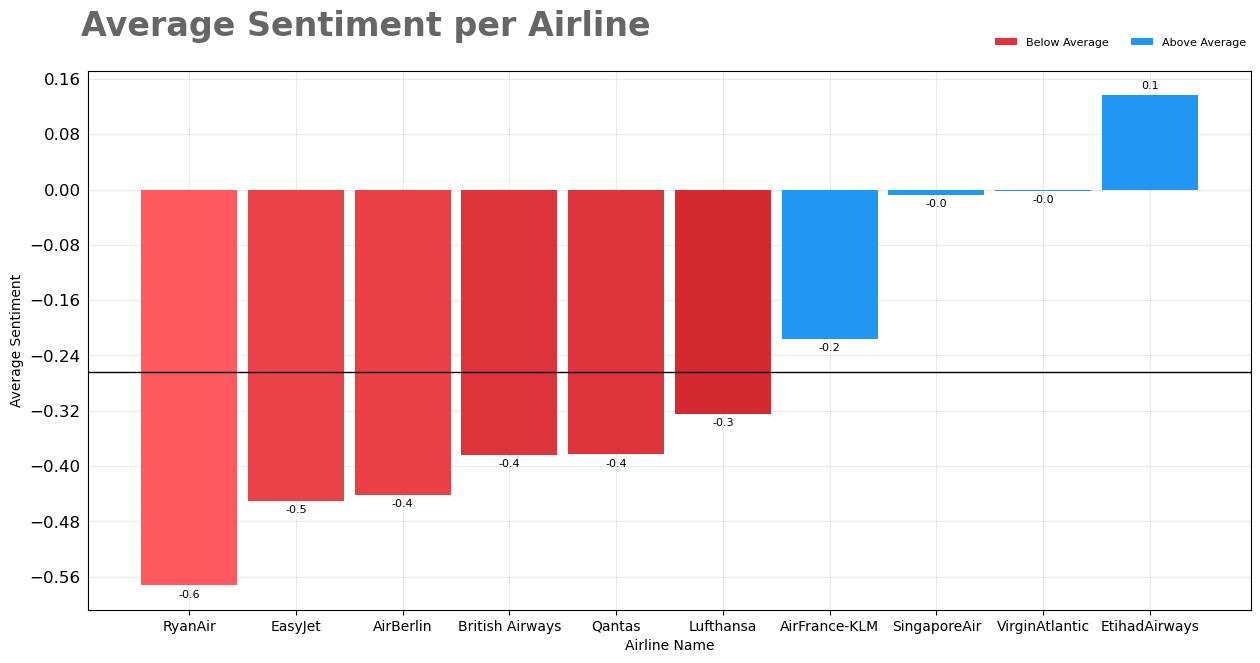

In [36]:
colours = ["#2196f3", "#bbdefb"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("colour_map", colours, N=256)
norm = mpl.colors.Normalize(df_mean_sentiments.sort_values(ascending=True, by='mean')['mean'].min(), df_mean_sentiments.sort_values(ascending=True, by='mean')['mean'].max()) # linearly normalizes data into the [0.0, 1.0] interval


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
bars = ax.bar(df_mean_sentiments.sort_values(ascending=True, by='mean')['index'], df_mean_sentiments.sort_values(ascending=True, by='mean')['mean'], width=0.9, color=cmap(norm(df_mean_sentiments.sort_values(ascending=True, by='mean')['mean'])), zorder=2)

ax.set_xlabel('Airline Name')
ax.text(x=0.12, y=.93, s="Average Sentiment per Airline", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# do the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

# roformat y axis
ax.set_ylabel('Average Sentiment')
ax.yaxis.set_label_position("left")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

# Add label on top of each bar
ax.bar_label(bars, labels=[f'{e:,.1f}' for e in df_mean_sentiments.sort_values(ascending=True, by='mean')['mean']], padding=3, color='black', fontsize=8)

colors_low = ["#ff5a5f", "#c81d25"] # Extreme colours of the high scale
colors_high = ["#2196f3","#bbdefb"] # Extreme colours of the low scale

# find the average
average = df_mean_sentiments.sort_values(ascending=True, by='mean')['mean'].mean()
below_average = df_mean_sentiments[df_mean_sentiments.sort_values(ascending=True, by='mean')['mean']<average]
above_average = df_mean_sentiments[df_mean_sentiments.sort_values(ascending=True, by='mean')['mean']>=average]

# Colormap - Build the colour maps
cmap_low = mpl.colors.LinearSegmentedColormap.from_list("low_map", colors_low, N=256)
cmap_high = mpl.colors.LinearSegmentedColormap.from_list("high_map", colors_high, N=256)
norm_low = mpl.colors.Normalize(df_mean_sentiments.sort_values(ascending=True, by='mean')['mean'].min(), average) # linearly normalizes data into the [0.0, 1.0] interval
norm_high = mpl.colors.Normalize(df_mean_sentiments.sort_values(ascending=True, by='mean')['mean'].max())

# Plot bars and average (horizontal) line
bars = ax.bar(below_average['index'], below_average['mean'], color=cmap_low(norm_low(below_average['mean'])), width=0.9, label='Below Average', zorder=2)
bars = ax.bar(above_average['index'], above_average['mean'], color=cmap_high(norm_high(above_average['mean'])), width=0.9, label='Above Average', zorder=2)
plt.axhline(y=average, color = 'black', linewidth=1)

ax.legend(loc="best", ncol=2, bbox_to_anchor=[1, 1.07], borderaxespad=0, frameon=False, fontsize=8);

# fig.get_figure().savefig('Average_sent_per_comp.png')

## Distribution of sentiment per airline 

In [37]:
britishairways_sentiment = britishairways_tweets[['sentiment_label', 'tweet_id']].groupby('sentiment_label').count().reset_index().rename(columns={'tweet_id':'British Airways'})
airfrance_klm_sentiment = airfrance_klm_tweets[['sentiment_label', 'tweet_id']].groupby('sentiment_label').count().reset_index().rename(columns={'tweet_id':'AirFrance-KLM'})
easyjet_sentiment = easyjet_tweets[['sentiment_label', 'tweet_id']].groupby('sentiment_label').count().reset_index().rename(columns={'tweet_id':'EasyJet'})
ryanair_sentiment = ryanair_tweets[['sentiment_label', 'tweet_id']].groupby('sentiment_label').count().reset_index().rename(columns={'tweet_id':'RyanAir'})
virginatlantic_sentiment = virginatlantic_tweets[['sentiment_label', 'tweet_id']].groupby('sentiment_label').count().reset_index().rename(columns={'tweet_id':'VirginAtlantic'})
lufthansa_sentiment = lufthansa_tweets[['sentiment_label', 'tweet_id']].groupby('sentiment_label').count().reset_index().rename(columns={'tweet_id':'Lufthansa'})
qantas_sentiment = qantas_tweets[['sentiment_label', 'tweet_id']].groupby('sentiment_label').count().reset_index().rename(columns={'tweet_id':'Qantas'})
etihadairways_sentiment = etihadairways_tweets[['sentiment_label', 'tweet_id']].groupby('sentiment_label').count().reset_index().rename(columns={'tweet_id':'EtihadAirways'})
singaporeair_sentiment = singaporeair_tweets[['sentiment_label', 'tweet_id']].groupby('sentiment_label').count().reset_index().rename(columns={'tweet_id':'SingaporeAir'})
airberlin_sentiment = airberlin_tweets[['sentiment_label', 'tweet_id']].groupby('sentiment_label').count().reset_index().rename(columns={'tweet_id':'AirBerlin'})

In [38]:
df_dist_sentiment = pd.merge(britishairways_sentiment, airfrance_klm_sentiment, on='sentiment_label')
df_dist_sentiment = pd.merge(df_dist_sentiment, easyjet_sentiment, on='sentiment_label')
df_dist_sentiment = pd.merge(df_dist_sentiment, ryanair_sentiment, on='sentiment_label')
df_dist_sentiment = pd.merge(df_dist_sentiment, virginatlantic_sentiment, on='sentiment_label')
df_dist_sentiment = pd.merge(df_dist_sentiment, lufthansa_sentiment, on='sentiment_label')
df_dist_sentiment = pd.merge(df_dist_sentiment, qantas_sentiment, on='sentiment_label')
df_dist_sentiment = pd.merge(df_dist_sentiment, etihadairways_sentiment, on='sentiment_label')
df_dist_sentiment = pd.merge(df_dist_sentiment, singaporeair_sentiment, on='sentiment_label')
df_dist_sentiment = pd.merge(df_dist_sentiment, airberlin_sentiment, on='sentiment_label').rename(columns={'sentiment_label': 'sentiment label'})

In [39]:
df_dist_sentiment = df_dist_sentiment.set_index('sentiment label').transpose().sort_values(by='negative', ascending=False)

In [40]:
df_dist_sentiment

sentiment label,negative,neutral,positive
RyanAir,246366,125184,21412
EasyJet,172474,105797,32452
British Airways,163981,73106,52826
Qantas,126104,82147,33508
AirFrance-KLM,92536,90931,43552
Lufthansa,77412,82547,19290
VirginAtlantic,32268,42128,32084
SingaporeAir,8270,17592,8004
EtihadAirways,7085,16761,11971
AirBerlin,342,253,55


Text(0, 0.5, 'Tweets Count')

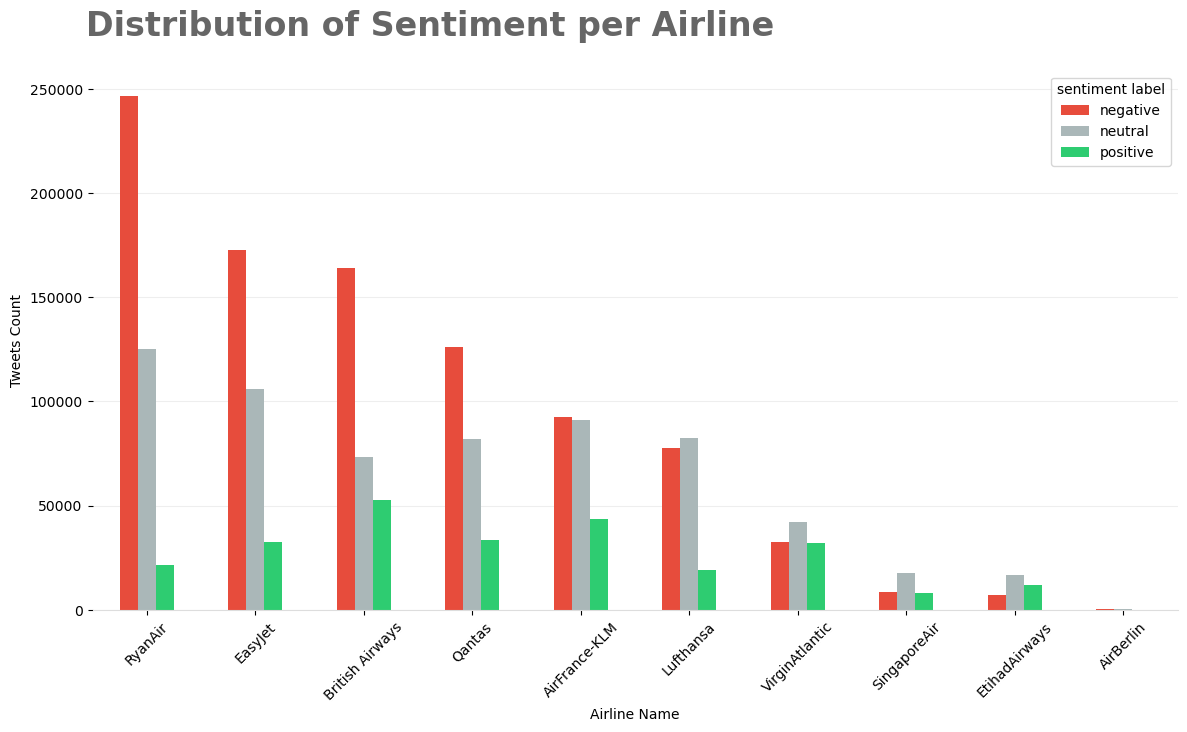

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))

bars_grouped = df_dist_sentiment.plot(kind='bar', ax=ax, color=['#E74C3C', '#AAB7B8', '#2ECC71'])

# title
ax.text(x=0.12, y=.93, s="Distribution of Sentiment per Airline", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)


# x axis 
ax.set_xlabel('Airline Name')
plt.xticks(rotation=45)

# y axis 
ax.set_ylabel('Tweets Count')


## Sentiment over time for EasyJet and British Airways

In [111]:
easyjet_tweets_vis = easyjet_tweets[['tweet_id', 'sentiment_label', 'sentiment_numeric', 'year', 'month', 'day', 'week', 'day_of_year']]
britishairways_tweets_vis = britishairways_tweets[['tweet_id', 'sentiment_label', 'sentiment_numeric', 'year', 'month', 'day', 'week','day_of_year' ]]

In [122]:
# get the data about easyjet over the year 
easyjet_neg_dof_df = easyjet_tweets_vis[easyjet_tweets_vis['sentiment_label']=='negative'].groupby('day_of_year').count()[['tweet_id']].reset_index().rename(columns={'tweet_id':'Negative'})
easyjet_neu_dof_df = easyjet_tweets_vis[easyjet_tweets_vis['sentiment_label']=='neutral'].groupby('day_of_year').count()[['tweet_id']].reset_index().rename(columns={'tweet_id':'Neutral'})
easyjet_pos_dof_df = easyjet_tweets_vis[easyjet_tweets_vis['sentiment_label']=='positive'].groupby('day_of_year').count()[['tweet_id']].reset_index().rename(columns={'tweet_id':'Positive'})

# get the data about british airways over the year 
britishairways_neg_dof_df = britishairways_tweets_vis[britishairways_tweets_vis['sentiment_label']=='negative'].groupby('day_of_year').count()[['tweet_id']].reset_index().rename(columns={'tweet_id':'Negative'})
britishairways_neu_dof_df = britishairways_tweets_vis[britishairways_tweets_vis['sentiment_label']=='neutral'].groupby('day_of_year').count()[['tweet_id']].reset_index().rename(columns={'tweet_id':'Neutral'})
britishairways_pos_dof_df = britishairways_tweets_vis[britishairways_tweets_vis['sentiment_label']=='positive'].groupby('day_of_year').count()[['tweet_id']].reset_index().rename(columns={'tweet_id':'Positive'})

In [190]:
easyjet_sent_all = pd.merge(easyjet_neg_dof_df, easyjet_neu_dof_df, on='day_of_year')
easyjet_sent_all = pd.merge(easyjet_sent_all, easyjet_pos_dof_df, on='day_of_year')


britishairways_sent_all = pd.merge(britishairways_neg_dof_df, britishairways_neu_dof_df, on='day_of_year')
britishairways_sent_all = pd.merge(britishairways_sent_all, britishairways_pos_dof_df, on='day_of_year')

In [191]:
def get_percentiles_neg(negative, neutral, positive):

    return negative / (negative + positive + neutral) * 100

def get_percentiles_neu(negative, neutral, positive):

    return neutral / (negative + positive + neutral) * 100

def get_percentiles_pos(negative, neutral, positive):

    return positive / (negative + neutral + positive) * 100

In [192]:
easyjet_sent_all['Negative_%'] = easyjet_sent_all.apply(lambda row: get_percentiles_neg(row['Negative'], row['Neutral'], row['Positive']), axis=1)
easyjet_sent_all['Neutral_%'] = easyjet_sent_all.apply(lambda row: get_percentiles_neu(row['Negative'], row['Neutral'], row['Positive']), axis=1)
easyjet_sent_all['Positive_%'] = easyjet_sent_all.apply(lambda row: get_percentiles_pos(row['Negative'], row['Neutral'], row['Positive']), axis=1)

britishairways_sent_all['Negative_%'] = britishairways_sent_all.apply(lambda row: get_percentiles_neg(row['Negative'], row['Neutral'], row['Positive']), axis=1)
britishairways_sent_all['Neutral_%'] = britishairways_sent_all.apply(lambda row: get_percentiles_neu(row['Negative'], row['Neutral'], row['Positive']), axis=1)
britishairways_sent_all['Positive_%'] = britishairways_sent_all.apply(lambda row: get_percentiles_pos(row['Negative'], row['Neutral'], row['Positive']), axis=1)

In [193]:
till = min(easyjet_sent_all.last_valid_index(), easyjet_sent_all.last_valid_index(), easyjet_sent_all.last_valid_index()) 
till2 = min(britishairways_sent_all.last_valid_index(), britishairways_sent_all.last_valid_index(), britishairways_sent_all.last_valid_index()) 

In [194]:
len(easyjet_sent_all['Negative_%'].loc[:till].to_list()), len(easyjet_sent_all['Neutral_%'].loc[:till].to_list()), len(easyjet_sent_all['Positive_%'].loc[:till].to_list())

(237, 237, 237)

In [195]:
len(britishairways_sent_all['Negative_%'].loc[:till].to_list()), len(britishairways_sent_all['Neutral_%'].loc[:till].to_list()), len(britishairways_sent_all['Positive_%'].loc[:till].to_list())

(237, 237, 237)

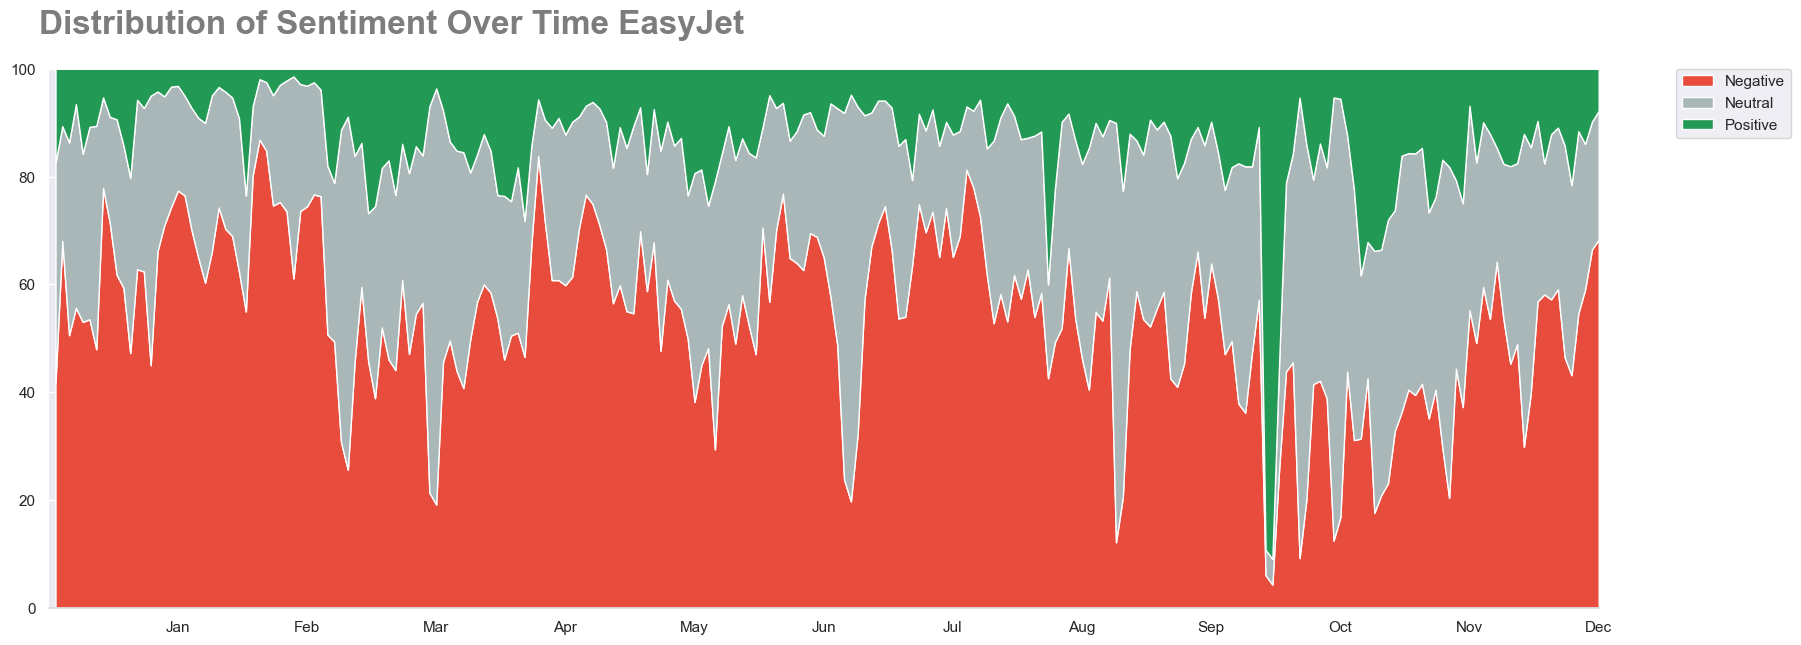

In [198]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,7))

x=range(1,229)
y1=easyjet_sent_all['Negative_%'].loc[:227].to_list()
y2=easyjet_sent_all['Neutral_%'].loc[:227].to_list()
y3=easyjet_sent_all['Positive_%'].loc[:227].to_list()


ax.stackplot(x, y1, y2, y3, labels=['Negative', 'Neutral', 'Positive'], colors=['#E74C3C', '#AAB7B8', '#229954'])
ax.legend(['Negative', 'Neutral', 'Positive'], )
ax.set_ylim(0,100)
ax.set_xlim(0,228)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# title
ax.text(x=0.12, y=.93, s="Distribution of Sentiment Over Time EasyJet", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

ax.set_xticks(ticks=[ 19, 38, 57, 76, 95, 114, 133, 152, 171, 190, 209, 228], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

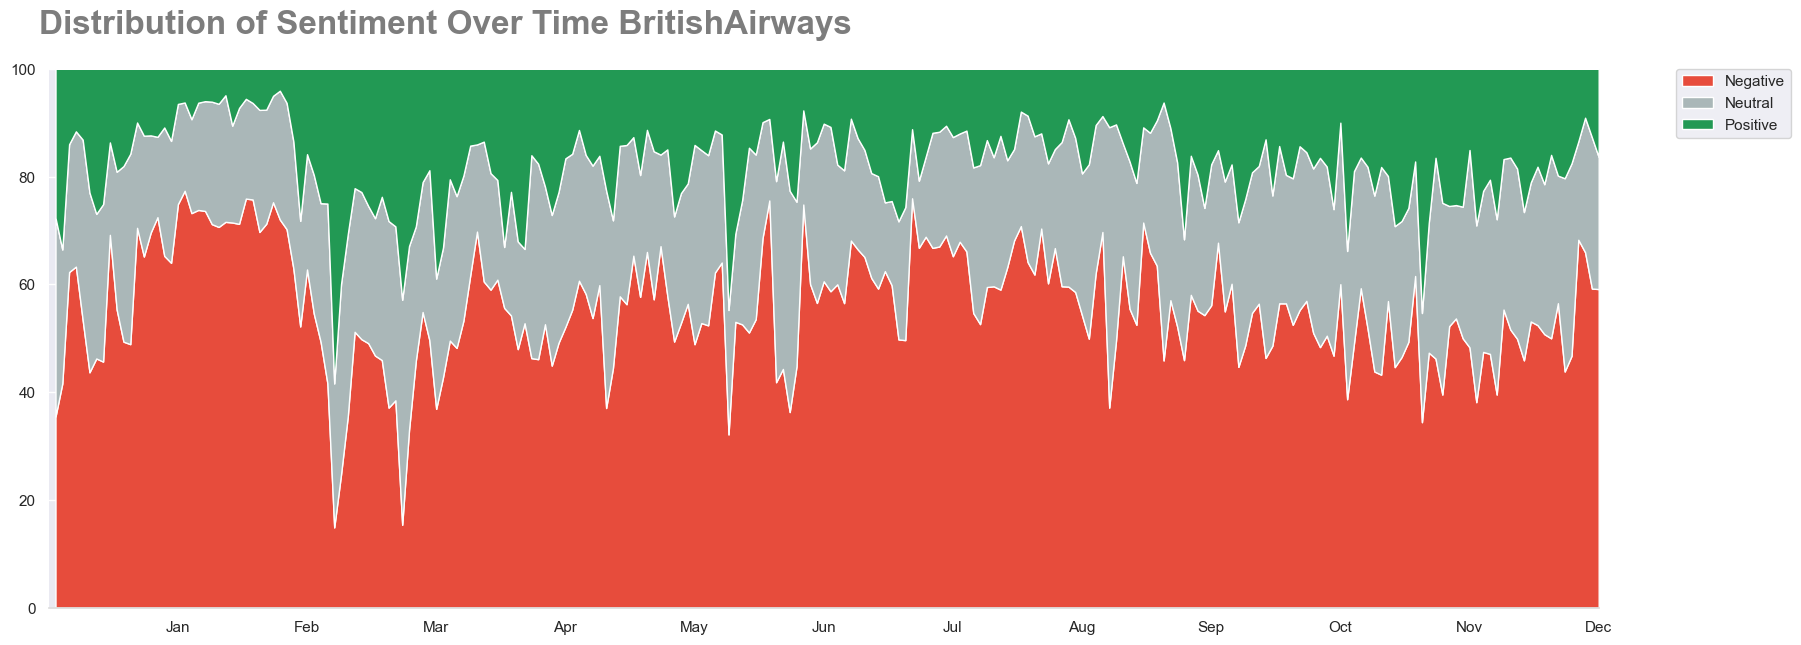

In [199]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,7))

x=range(1,229)
y1=britishairways_sent_all['Negative_%'].loc[:227].to_list()
y2=britishairways_sent_all['Neutral_%'].loc[:227].to_list()
y3=britishairways_sent_all['Positive_%'].loc[:227].to_list()


ax.stackplot(x, y1, y2, y3, labels=['Negative', 'Neutral', 'Positive'], colors=['#E74C3C', '#AAB7B8', '#229954'])
ax.legend(['Negative', 'Neutral', 'Positive'], )
ax.set_ylim(0,100)
ax.set_xlim(0,228)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# title
ax.text(x=0.12, y=.93, s="Distribution of Sentiment Over Time BritishAirways", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

ax.set_xticks(ticks=[ 19, 38, 57, 76, 95, 114, 133, 152, 171, 190, 209, 228], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);